In [41]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import sys
import neuroglancer
import scipy.misc

from tqdm import tqdm
from skimage import io
from ndpull import ndpull
import pandas as pd 
from skimage import measure
from scipy.ndimage import morphology
from at_synapse_detection import dataAccess as da
from at_synapse_detection import SynapseDetection as syn

In [42]:
%matplotlib notebook

In [43]:
# LM image filepaths 
psd_fn = 'collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49/collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49_PSD95_0.tiff'
synapsin_fn = 'collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49/collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49_synapsin_0.tiff'

# gaba_fn = 'collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49/collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49_GABA_0.tiff'
# gad_fn = 'collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49/collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49_GAD2_0.tiff'
# gephyrin_fn = 'collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49/collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49_Gephyrin_0.tiff'
# glun1_fn = 'collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49/collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49_GluN1_0.tiff'
# vglut1_fn = 'collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49/collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP_0_438_0_460_0_49_VGlut1_0.tiff'

In [44]:
fn_list = [psd_fn, synapsin_fn] #, gaba_fn, gad_fn, gephyrin_fn, glun1_fn, vglut1_fn]
fn_name = ['PSD-95', 'Synapsin'] #, 'GABA', 'GAD', 'Gephyrin', 'GLUN1', 'VGLUT1']

In [45]:
# Load annotations 
lm_labels_dict = np.load('lm_labels_dict.npy').item()

In [46]:
SE = morphology.generate_binary_structure(2, 2)
SE

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [47]:
SE2 = np.ones((4, 4), dtype=bool)
foo

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [48]:
def evaluate_detections(resultVol): 
    """
    Evaluate RORB annotations with LM volume
    
    Parameters
    --------------
    resultVol : 3D numpy array 
    
    Returns
    --------------
    output_mat  
    detections
    """
    
    thresh  =  0.9 # This is a constant
    bw_vol  = resultVol > thresh
#     label_vol = measure.label(bw_vol > thresh)
#     stats = measure.regionprops(label_vol)
    
    # Dilate detections 
    SE2 = np.ones((4, 4), dtype=bool)

    SE = morphology.generate_binary_structure(2, 2)
    bw_vol_dilate = np.copy(bw_vol)
    for z in range(0, bw_vol.shape[2]): 
        bw_vol_dilate[:, :, z] = morphology.binary_dilation(bw_vol[:, :, z], SE)
        
    #create mask 
    maskvol = np.zeros((460, 438, 49))
#     global_minx = 152
#     global_maxx = 288
#     global_miny = 149
#     global_maxy = 317
    global_minx = 145
    global_maxx = 325
    global_miny = 145
    global_maxy = 325
    maskvol[global_minx:global_maxx, global_miny:global_maxy, :] = 1 
    
    # Mask detections to match label region
    masked_detections_vol = maskvol*bw_vol_dilate
    
    # Run regionprops
    label_vol = measure.label(masked_detections_vol)
    detections = measure.regionprops(label_vol)
    print('Number of detections: ', len(detections))
    
    detection_vol = np.copy(label_vol)

    hit_count = 0
    miss_count = 0
    shape = (460, 438, 49)
    output_mat = np.zeros((len(lm_labels_dict.keys()), len(detections)))

    for label_ind, key in enumerate(lm_labels_dict.keys()): 

        synapse_label = lm_labels_dict[key]
        single_label_vol = make_label_vol(synapse_label, shape)

        label_detection_vol = single_label_vol*detection_vol
        unique_vals = np.unique(label_detection_vol)

        if len(unique_vals) > 1: 
            index = np.argwhere(unique_vals==0)
            unique_vals = np.abs(np.delete(unique_vals, index))
            output_mat[label_ind, unique_vals] = 1 
            hit_count = hit_count + 1 
        else: 
            miss_count = miss_count + 1 
            
    print('Hit Count: ', hit_count)
    print('Miss Count: ', miss_count)

    return output_mat, detections

In [49]:
def make_label_vol(synapse_label, shape): 
    """This returns a volume of all zeros, expect where the synapse_label indicates. Those values are -1"""
    labelvol = np.zeros(shape, dtype=np.int64)
    for n in range(0, synapse_label.shape[0]): 
        labelvol[synapse_label[n][0], synapse_label[n][1], synapse_label[n][2]] = -1
    
    return labelvol

In [50]:
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

In [57]:
def result_to_tiff(result_vol, fn_base='result_', thresh=0.9, offset=0): 
    bw_vol = result_vol > thresh
    bw_vol = bw_vol*1
    for n in range(0, resultVol.shape[2]): 
        scipy.misc.imsave(fn_base + str(n+offset).zfill(2) + '.tiff', bw_vol[:, :, n])
    
    

See which annotations overlap with a channel

In [52]:
# Evaluate LM signal overlap with labels
lm_overlap = np.zeros((len(lm_labels_dict.keys()), len(fn_list)))
lm_detections = [] 
lm_output_mat_list = [] 

for fn_ind, fn in enumerate(fn_list): 
    vol = da.imreadtiff(fn)
    synaptic_volumes = {'presynaptic': [], 'postsynaptic': [vol]}
    min_num_of_slices = 1
    # Create query
    query = {'preIF': ['presynaptic'], 'preIF_z': [],
             'postIF': ['postsynaptic'], 'postIF_z': [min_num_of_slices],
             'punctumSize': 2}
    
    resultVol = syn.getSynapseDetections(synaptic_volumes, query) 
    output_mat, detections = evaluate_detections(resultVol)
    
    lm_detections.append(detections)
    lm_output_mat_list.append(output_mat)
    
    lm_overlap[:, fn_ind] = np.sum(output_mat, 1)
    
    print('Done with ', fn_name[fn_ind])

starting z ind: 0
starting z ind: 1
starting z ind: 2
starting z ind: 3
starting z ind: 4
starting z ind: 5
starting z ind: 6
starting z ind: 7
starting z ind: 8
starting z ind: 9
starting z ind: 10
starting z ind: 11
starting z ind: 12
starting z ind: 13
starting z ind: 14
starting z ind: 15
starting z ind: 16
starting z ind: 17
starting z ind: 18
starting z ind: 19
starting z ind: 20
starting z ind: 21
starting z ind: 22
starting z ind: 23
starting z ind: 24
starting z ind: 25
starting z ind: 26
starting z ind: 27
starting z ind: 28
starting z ind: 29
starting z ind: 30
starting z ind: 31
starting z ind: 32
starting z ind: 33
starting z ind: 34
starting z ind: 35
starting z ind: 36
starting z ind: 37
starting z ind: 38
starting z ind: 39
starting z ind: 40
starting z ind: 41
starting z ind: 42
starting z ind: 43
starting z ind: 44
starting z ind: 45
starting z ind: 46
starting z ind: 47
starting z ind: 48
Number of detections:  2963
Hit Count:  819
Miss Count:  222
Done with  PSD-95


Evaluate Synapse Detection 

In [53]:
synapse_signal_mat = np.zeros((len(lm_labels_dict.keys()), 1))

psd_vol = da.imreadtiff(psd_fn)
synapsin_vol = da.imreadtiff(synapsin_fn)

synaptic_volumes = {'presynaptic': [synapsin_vol], 'postsynaptic': [psd_vol]}
min_num_of_slices = 1

# Create query
query = {'preIF': ['presynaptic'], 'preIF_z': [min_num_of_slices],
         'postIF': ['postsynaptic'], 'postIF_z': [min_num_of_slices],
         'punctumSize': 2}

resultVol = syn.getSynapseDetections(synaptic_volumes, query)

output_mat, synapse_detections = evaluate_detections(resultVol)
synapse_signal_mat[:, 0] = np.sum(output_mat, 1)
print('Done with PSD, Synapsin Query')

starting z ind: 0
starting z ind: 1
starting z ind: 2
starting z ind: 3
starting z ind: 4
starting z ind: 5
starting z ind: 6
starting z ind: 7
starting z ind: 8
starting z ind: 9
starting z ind: 10
starting z ind: 11
starting z ind: 12
starting z ind: 13
starting z ind: 14
starting z ind: 15
starting z ind: 16
starting z ind: 17
starting z ind: 18
starting z ind: 19
starting z ind: 20
starting z ind: 21
starting z ind: 22
starting z ind: 23
starting z ind: 24
starting z ind: 25
starting z ind: 26
starting z ind: 27
starting z ind: 28
starting z ind: 29
starting z ind: 30
starting z ind: 31
starting z ind: 32
starting z ind: 33
starting z ind: 34
starting z ind: 35
starting z ind: 36
starting z ind: 37
starting z ind: 38
starting z ind: 39
starting z ind: 40
starting z ind: 41
starting z ind: 42
starting z ind: 43
starting z ind: 44
starting z ind: 45
starting z ind: 46
starting z ind: 47
starting z ind: 48
Number of detections:  1185
Hit Count:  566
Miss Count:  475
Done with PSD, Syn

In [54]:
# output_mat, synapse_detections = evaluate_detections(resultVol)
# synapse_signal_mat[:, 0] = np.sum(output_mat, 1)
# print('Done with PSD, Synapsin Query')

In [55]:
output_mat.shape

(1041, 1185)

In [58]:
result_to_tiff(resultVol)

Create neuroglancer links

In [ ]:
ng_server="https://viz.boss.neurodata.io"
ng_url="https://viz.boss.neurodata.io/#!%7B'layers':%7B'em_clahe':%7B'type':'image'_'source':'boss://https://api.boss.neurodata.io/collman/M247514_Rorb_1_Site3Align2_EM/em_clahe'%7D_'PSD95':%7B'type':'image'_'source':'boss://https://api.boss.neurodata.io/collman/M247514_Rorb_1_Site3Align2_LENS_Session1_CROP/PSD95?'_'blend':'additive'_'color':1_'max':0.63%7D_'synapsin':%7B'type':'image'_'source':'boss://https://api.boss.neurodata.io/collman/M247514_Rorb_1_Site3Align2_LENS_Session1_CROP/synapsin?'_'blend':'additive'_'color':2_'max':0.66%7D_'m247514_Site3Annotation_MN_global':%7B'type':'segmentation'_'source':'boss://https://api.boss.neurodata.io/collman/M247514_Rorb_1_Site3Align2_EM/m247514_Site3Annotation_MN_global'%7D%7D_'navigation':%7B'pose':%7B'position':%7B'voxelSize':%5B96_96_50%5D_'voxelCoordinates':%5B251.3346405029297_256.0650939941406_23%5D%7D%7D_'zoomFactor':3.125%7D%7D"
state=neuroglancer.parse_url(ng_url)


In [ ]:
# Generate URLs
miss_count = 0
keylist = list(lm_labels_dict.keys())
htmllist = [] 

for label_ind in range(0, len(keylist)): 
    synapse_label = lm_labels_dict[keylist[label_ind]]
    midpoint = np.mean(synapse_label, 0)
    midpoint = np.round(midpoint)
    miss_count = miss_count + 1 
    state.position.voxelCoordinates=[midpoint[1],midpoint[0],midpoint[2]]
    link = """<a href="%s">%s</a> """%(neuroglancer.to_url(state,ng_server),'synapse_'+str(keylist[label_ind]))
    htmllist.append(link)
    



In [ ]:
result_labels = ['Has PSD-95', 'Has Synapsin', 'Detected', 'link']
df = pd.DataFrame(np.nan, index=keylist, columns=result_labels)
df.iloc[:, 0] = 1*(lm_overlap[:, 0] > 0)
df.iloc[:, 1] = 1*(lm_overlap[:, 1] > 0)
df.iloc[:, 2] = 1*(synapse_signal_mat[:, 0] > 0)
df.iloc[:, 3] = htmllist

# Result Table 

To see the labeled synapse in NDViz, click the very last column. 

In [ ]:
df.style.format(make_clickable)

In [ ]:
df.to_csv('/Users/anish/Documents/Connectome/rorb-analysis/test.csv')

### Create histograms

Number of detections per EM-synapse-label

In [20]:
split_anno_list = []
keylist = list(lm_labels_dict.keys())

for label_ind, key in enumerate(keylist): 
    zlabel = lm_labels_dict[key][:, 2]
    zlabel = np.unique(zlabel)
    diff_zlabel = np.diff(zlabel)
    if any(diff_zlabel > 1): 
        print(key)
        split_anno_list.append(key)
 

1.0
2.0
5
7.0
85
116.0
142.0
143.0
150.0
169.0
272.0
276.0
279.0
286.0
290.0
303.0
401.0
463.0
535.0
576.0
606.0
607.0
644.0
711.0
718.0
867.0
913.0


In [21]:
detections_per_emlabel = np.sum(output_mat, 1)

In [24]:
zero_hits = 0 
one_hit = 0 
two_hits = 0 
nopsd = 0
nosynapsin = 0
splitanno = 0 

miss_list = [] 
hit_list = [] 


overlap_with_psd = (lm_overlap[:, 0])
overlap_with_synapsin = (lm_overlap[:, 1])

for label_ind in range(0, len(keylist)): 
    
    if overlap_with_psd[label_ind] > 0: 
        if overlap_with_synapsin[label_ind] > 0:
            
            if keylist[label_ind] not in split_anno_list: 
                if detections_per_emlabel[label_ind]==0: 
                    zero_hits = zero_hits + 1
                    miss_list.append(keylist[label_ind])
                elif detections_per_emlabel[label_ind]==1: 
                    one_hit = one_hit + 1 
                    hit_list.append(keylist[label_ind])
                else: 
                    two_hits = two_hits + 1 
                    hit_list.append(keylist[label_ind])
            else: 
                splitanno = splitanno + 1
        else: 
            nosynapsin = nosynapsin + 1 
    else: 
        nopsd = nopsd + 1
        
total_labels = zero_hits+one_hit+two_hits
print("No PSD: ", nopsd)
print("No Synapsin: ", nosynapsin)
print('Split Anno', splitanno)
print('Zero Hits: ', zero_hits)
print('One Hit: ', one_hit)
print('Two Hits: ', two_hits)
print('Percentage of labels detected: ', (one_hit+two_hits)/total_labels)

No PSD:  192
No Synapsin:  128
Split Anno 23
Zero Hits:  151
One Hit:  494
Two Hits:  53
Percentage of labels detected:  0.7836676217765043


In [25]:
151+494+53

698

<IPython.core.display.Javascript object>


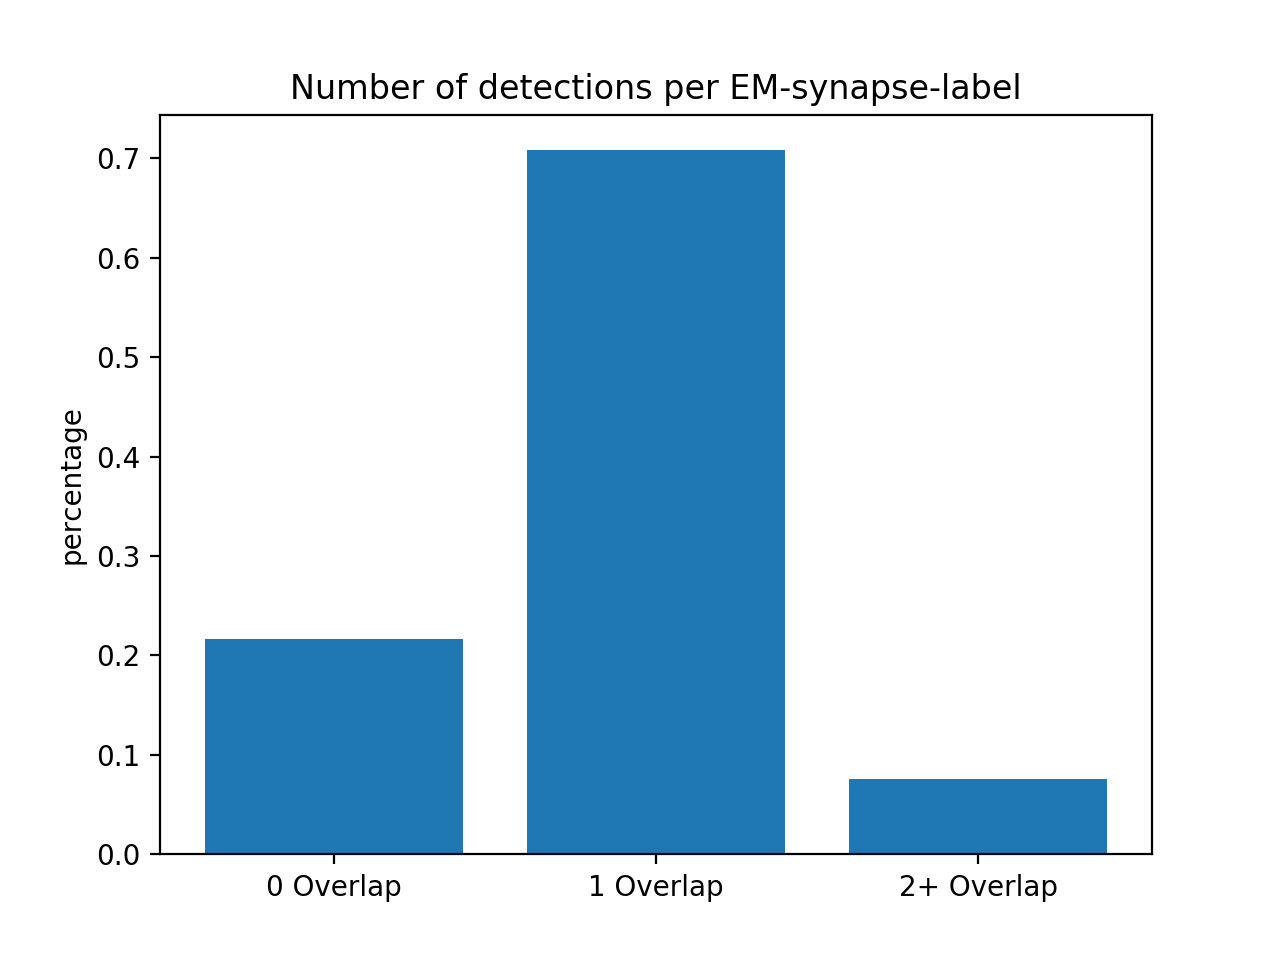

([<matplotlib.axis.XTick at 0x10c739320>,
 <a list of 3 Text xticklabel objects>)

In [26]:
plt.figure()
plt.bar([0, 1, 2], [zero_hits/total_labels, one_hit/total_labels, two_hits/total_labels])
plt.ylabel('percentage')
plt.title('Number of detections per EM-synapse-label')
plt.xticks([0, 1, 2], ['0 Overlap', '1 Overlap', '2+ Overlap'])

In [27]:
def get_labeled_detections(fn):
    """Process individual IF channel """
    
    vol = da.imreadtiff(fn)
    synaptic_volumes = {'presynaptic': [], 'postsynaptic': [vol]}
    min_num_of_slices = 1
    query = {'preIF': ['presynaptic'], 'preIF_z': [],
             'postIF': ['postsynaptic'], 'postIF_z': [min_num_of_slices],
             'punctumSize': 2}

    prob_vol = syn.getSynapseDetections(synaptic_volumes, query) 

    thresh  =  0.9 
    bw_vol  = prob_vol > thresh

    # Dilate detections 
    SE = morphology.generate_binary_structure(2, 2)
    bw_vol_dilate = np.copy(bw_vol)
    for z in range(0, bw_vol.shape[2]): 
        bw_vol_dilate[:, :, z] = morphology.binary_dilation(bw_vol[:, :, z], SE)

    #create mask 
    maskvol = np.zeros((460, 438, 49))
    global_minx = 145
    global_maxx = 325
    global_miny = 145
    global_maxy = 325
    maskvol[global_minx:global_maxx, global_miny:global_maxy, :] = 1 

    # Mask detections to match label region
    masked_detections_vol = maskvol*bw_vol_dilate

    # Run regionprops
    detection_label_vol = measure.label(masked_detections_vol)
    detections = measure.regionprops(detection_label_vol)
    print('Number of detections: ', len(detections))

    return detection_label_vol, detections

In [28]:
180*180*0.1*0.1*.05*48

777.5999999999999

In [29]:
def get_z_inds(single_label_vol, IF_detection_vol, IF_detections): 

    label_detection_vol = single_label_vol*IF_detection_vol
    unique_vals = np.unique(label_detection_vol)

    if len(unique_vals) > 1: 
        index = np.argwhere(unique_vals==0)
        unique_vals = np.abs(np.delete(unique_vals, index))

    z_inds = np.unique(IF_detections[unique_vals[0]-1].coords[:, 2])
    
    centroid = IF_detections[unique_vals[0]-1].centroid
    
    return z_inds, centroid

In [30]:
def get_dist(a, b): 
    dist = np.sqrt(np.power((a[0]-b[0]), 2) + np.power((a[1]-b[1]), 2) + np.power((a[2]-b[2]), 2))
    return dist

In [31]:
psd_detection_vol, psd_detections = get_labeled_detections(fn_list[0])
synapsin_detection_vol, synapsin_detections = get_labeled_detections(fn_list[1])



starting z ind: 0
starting z ind: 1
starting z ind: 2
starting z ind: 3
starting z ind: 4
starting z ind: 5
starting z ind: 6
starting z ind: 7
starting z ind: 8
starting z ind: 9
starting z ind: 10
starting z ind: 11
starting z ind: 12
starting z ind: 13
starting z ind: 14
starting z ind: 15
starting z ind: 16
starting z ind: 17
starting z ind: 18
starting z ind: 19
starting z ind: 20
starting z ind: 21
starting z ind: 22
starting z ind: 23
starting z ind: 24
starting z ind: 25
starting z ind: 26
starting z ind: 27
starting z ind: 28
starting z ind: 29
starting z ind: 30
starting z ind: 31
starting z ind: 32
starting z ind: 33
starting z ind: 34
starting z ind: 35
starting z ind: 36
starting z ind: 37
starting z ind: 38
starting z ind: 39
starting z ind: 40
starting z ind: 41
starting z ind: 42
starting z ind: 43
starting z ind: 44
starting z ind: 45
starting z ind: 46
starting z ind: 47
starting z ind: 48
Number of detections:  2963
starting z ind: 0
starting z ind: 1
starting z ind:

In [32]:
a = synapsin_detections[3].centroid

In [33]:
b = psd_detections[3].centroid

In [34]:
a, b

((146.5, 145.0, 41.0), (145.5, 150.5, 5.0))

In [35]:
np.power((a[0]-b[0]), 2)

1.0

In [37]:
disjoint_signal = 0 
distance_between_blobs = []
shape = (460, 438, 49)

for key in miss_list: 
    synapse_label = lm_labels_dict[key]
    single_label_vol = make_label_vol(synapse_label, shape)

    psd_z_inds, psd_centroid = get_z_inds(single_label_vol, psd_detection_vol, psd_detections)
    synapsin_z_inds, synapsin_centroid = get_z_inds(single_label_vol, synapsin_detection_vol, synapsin_detections)

    result = set(synapsin_z_inds).intersection(psd_z_inds)
    
    if len(result) == 0: 
#         print(key)
#         print('psd z inds', psd_z_inds)
#         print('synapsin z inds', synapsin_z_inds)
        disjoint_signal = disjoint_signal + 1 
        
    dist = get_dist(psd_centroid, synapsin_centroid)
    distance_between_blobs.append(dist)
    
    
print("disjoint_signal", disjoint_signal)


disjoint_signal 64


In [ ]:
np.mean(distance_between_blobs)

In [ ]:
30/120

In [ ]:
hit_list

In [ ]:
disjoint_signal = 0 
distance_between_blobs = []

for key in hit_list: 
    synapse_label = lm_labels_dict[key]
    single_label_vol = make_label_vol(synapse_label, shape)

    psd_z_inds, psd_centroid = get_z_inds(single_label_vol, psd_detection_vol, psd_detections)
    synapsin_z_inds, synapsin_centroid = get_z_inds(single_label_vol, synapsin_detection_vol, synapsin_detections)

    result = set(synapsin_z_inds).intersection(psd_z_inds)
    
    if len(result) == 0: 
        disjoint_signal = disjoint_signal + 1 
        
    dist = get_dist(psd_centroid, synapsin_centroid)
    distance_between_blobs.append(dist)
    
    
print("disjoint_signal", disjoint_signal)


In [ ]:
distance_between_blobs

In [38]:
14215*11123*0.096*0.096*101*0.05

7358726.221056001